In [126]:
!python3 -m pip install nltk

You should consider upgrading via the '/Users/alex/.env/bin/python3 -m pip install --upgrade pip' command.


In [150]:
import re
import time
import string
import random
import datetime
import itertools
import collections
import h5py
import typing
import sklearn
import transformers
import copy
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup, RobertaTokenizer, RobertaModel
import torch
import nltk
from nltk.tokenize import word_tokenize
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils import data
#import allennlp
#from allennlp.modules.elmo import Elmo, batch_to_ids
#from allennlp.commands.elmo import ElmoEmbedder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from wordcloud import WordCloud, STOPWORDS
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences as pad

Using TensorFlow backend.


In [148]:
def remove_stopwords(text):
        if text is not None:
            tokens = [x for x in word_tokenize(text) if x not in stop]
            return " ".join(tokens)
        else:
            return None

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def plot_distrib_train_test(train, test):
    fig=make_subplots(1,2,subplot_titles=('Training set','Test set'))
    x=train.sentiment.value_counts()
    fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['orange','green','red'],name=''),row=1,col=1)
    x=test.sentiment.value_counts()
    fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['orange','green','red'],name=''),row=1,col=2)
    fig.show()

def show_word_distrib(df, target="positive", field="text", top_N=10, selected=True):
    fig = plt.figure()
    
    txt = df[df['sentiment']==target][field].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
    words = nltk.tokenize.word_tokenize(txt)
    words_except_stop_dist = nltk.FreqDist(words) 
    
    rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                        columns=['Word', 'Frequency Text']).set_index('Word')
    print(rslt)
    #matplotlib.style.use('ggplot')
    ax1 = fig.add_subplot()
    rslt.plot.bar(rot=0, ax=ax1)
    
    if selected:
        txt = df[df['sentiment']==target]["selected_text"].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
        words = nltk.tokenize.word_tokenize(txt)
        words_except_stop_dist = nltk.FreqDist(words) 

        rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                            columns=['Word', 'Frequency Selected Text']).set_index('Word')
        
        print(rslt)
        #matplotlib.style.use('ggplot')
        ax2 = fig.add_subplot()
        rslt.plot.bar(rot=0, ax=ax2)
    plt.show()
    
    
def general_stats(train, test):
    n_train = len(train)
    n_test = len(test)
    
    print("Number of train samples: {}".format(n_train))
    print("Number of test samples: {}".format(n_test))
    plot_distrib_train_test(train, test)
    
    print("Word distribution of 'text' and 'selected_text' in Training set for positive samples")
    show_word_distrib(train, target="positive")
    
    print("Word distribution of 'text' and 'selected_text' in Training set for neutral samples")
    show_word_distrib(train, target="neutral")
    
    print("Word distribution of 'text' and 'selected_text' in Training set for negative samples")
    show_word_distrib(train, target="negative")
    
    
    print("Word distribution of 'text' in Test set for positive samples")
    show_word_distrib(test, target="positive", selected=False)
    
    print("Word distribution of 'text' in Test set for neutral samples")
    show_word_distrib(test, target="neutral", selected=False)
    
    print("Word distribution of 'text' in Test set for negative samples")
    show_word_distrib(test, target="negative", selected=False)
    

def plot_hist_classes(df, to_plot, _header, col="text"):
    fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(10,5))
    
    df_len = to_plot(df, "negative", col=col)
    ax1.hist(df_len,color='red')
    ax1.set_title('Negative Tweets')
    
    df_len = to_plot(df, "positive", col=col)
    ax2.hist(df_len,color='green')
    ax2.set_title('Positive Tweets')
    
    df_len = to_plot(df, "neutral", col=col)
    ax3.hist(df_len,color='orange')
    ax3.set_title('Neutral Tweets')
    
    
    fig.suptitle(_header)
    plt.show()
    plt.close()
    

def average_word_lenght(df,col="text"):
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,5))
    
    word=df[df['sentiment']=="negative"][col].str.split().apply(lambda x : [len(i) for i in x])
    sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
    ax1.set_title('Negative')
    
    word=df[df['sentiment']=="positive"][col].str.split().apply(lambda x : [len(i) for i in x])
    sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
    ax2.set_title('Positive')
    
    word=df[df['sentiment']=="neutral"][col].str.split().apply(lambda x : [len(i) for i in x])
    sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='orange')
    ax2.set_title('Neutral')
    
    fig.suptitle('Average word length in each tweet')
    plt.show()
    

def unique_words(df, col="text", title="Distribution of number of unique words"):
    fig,ax=plt.subplots(1,3,figsize=(12,7))
    colors = {
        "positive": "green",
        "negative": "red",
        "neutral": "orange"
    }
    for _, i in enumerate(["positive", "negative", "neutral"]):
        new=df[df['sentiment']==i][col].map(lambda x: len(set(x.split())))
        sns.distplot(new.values,ax=ax[_],color=colors[i])
        ax[_].set_title(i)
    fig.suptitle(title)
    fig.show()
    
def get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n),stop_words=stop).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]
    
def plot_n_grams(df, size=2, 
                 title="Common bigrams in selected text",
                 column="text"):
    colors = {
        "positive": "green",
        "negative": "red",
        "neutral": "orange"
    }
    
    fig,ax=plt.subplots(1,3,figsize=(18,10))
    for _, i in enumerate(["positive", "negative", "neutral"]):
        new=df[df['sentiment']==i][column]
        top_n_bigrams=get_top_ngram(new,size)[:20]
        x,y=map(list,zip(*top_n_bigrams))
        sns.barplot(x=y,y=x,ax=ax[_],color=colors[i])
        ax[_].set_title(i)
    
    fig.suptitle(title)
    fig.show()
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_punct(text):
    exclude = set(string.punctuation)
    s = ''.join(ch for ch in text if ch not in exclude)
    return s

def clean_df(df, train=True):
    df["dirty_text"] = df['text']
    
    
    df["text"] = df['text'].apply(lambda x : str(x).lower())
    
    df['text']=df['text'].apply(lambda x: remove_emoji(str(x)))
        
    df['text']=df['text'].apply(lambda x : remove_URL(str(x)))
        
    df['text']=df['text'].apply(lambda x : remove_html(str(x)))
        
    df['text'] =df['text'].apply(lambda x : remove_stopwords(str(x)) )
    
    df['text']=df['text'].apply(lambda x : remove_punct(str(x)))
    
    df.text = df.text.replace('\s+', ' ', regex=True)
    
    if train:
        df["selected_text"] = df['selected_text'].apply(lambda x : str(x).lower())
        df['selected_text']=df['selected_text'].apply(lambda x: remove_emoji(str(x)))
        df['selected_text']=df['selected_text'].apply(lambda x : remove_URL(str(x)))
        df['selected_text']=df['selected_text'].apply(lambda x : remove_html(str(x)))
        df['selected_text'] =df['selected_text'].apply(lambda x : remove_stopwords(str(x)))
        df['selected_text']=df['selected_text'].apply(lambda x : remove_punct(str(x)))
        df.selected_text = df.selected_text.replace('\s+', ' ', regex=True)
    
    return df

In [10]:
def basic_cleaning(text):
    text=re.sub(r'https?://www\.\S+\.com','',text)
    text=re.sub(r'[^A-Za-z|\s]','',text)
    return text

def clean(df):
    for col in ['text','selected_text']:
        df[col]=df[col].astype(str).apply(lambda x:basic_cleaning(x))
    return df

In [11]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [110]:
# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=600, 
                    height=300,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    


In [12]:
sns.set_style("darkgrid")

In [68]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/tweet-sentiment-extraction/train.csv


In [69]:
df = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")

In [70]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [71]:
df['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

Text(0.5, 1.0, 'Distribution of number of tweets prior to sentiment')

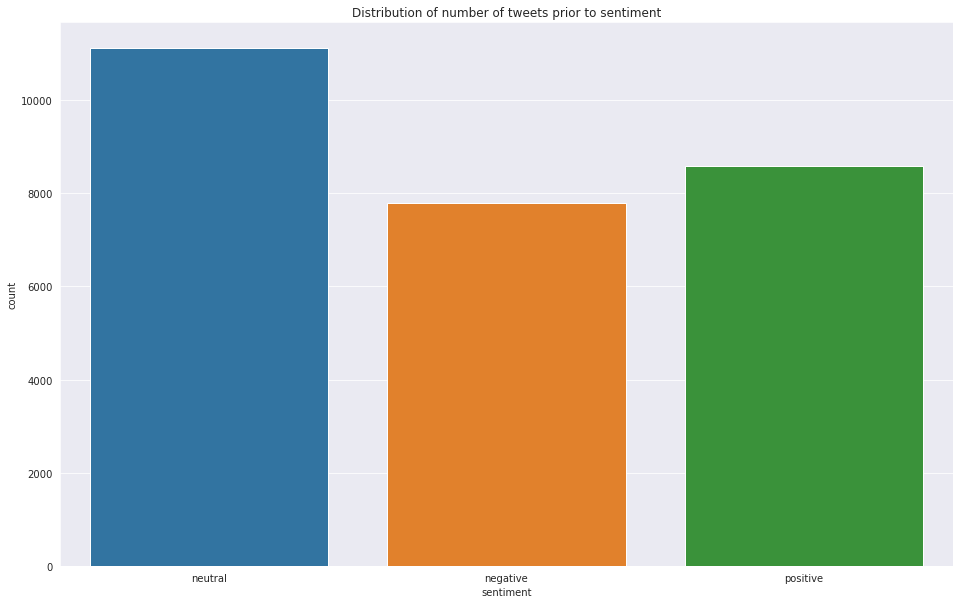

In [72]:
fig = plt.figure(figsize=(16,10))
sns.categorical.countplot(df['sentiment'])
plt.title("Distribution of number of tweets prior to sentiment")

Наблюдается некоторый дисбаланс классов.

In [73]:
groups = df.groupby('sentiment')['text']

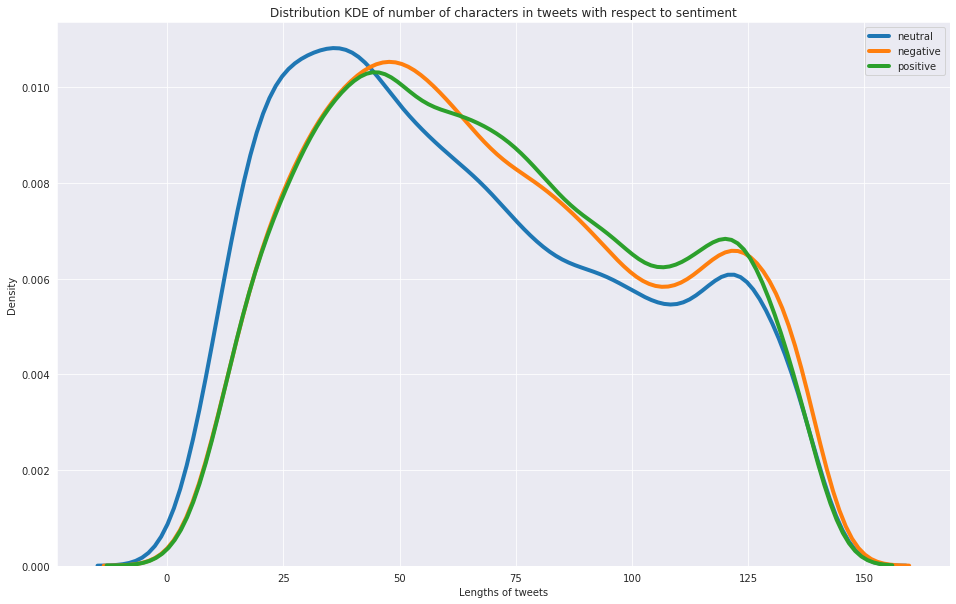

In [74]:
fig = plt.figure(figsize=(16,10))
for sentiment in df['sentiment'].unique():
    sns.distplot(groups.get_group(sentiment).apply(lambda item: len(item) if type(item) == str else len(str(item))),
                hist=False,
                 kde=True,
                 bins=20,
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4},
                label=sentiment);
#plt.axvline(np.quantile(df['text'].apply(lambda item: len(item) if type(item) == str else len(str(item))), 0.05), 0, 17, linewidth=4, color="red")
#plt.axvline(np.quantile(df['text'].apply(lambda item: len(item) if type(item) == str else len(str(item))), 0.95), 0, 17, linewidth=4, color="red")
plt.title('Distribution KDE of number of characters in tweets with respect to sentiment')
plt.xlabel('Lengths of tweets')
plt.ylabel('Density');

In [75]:
sentiments = df['sentiment'].unique()

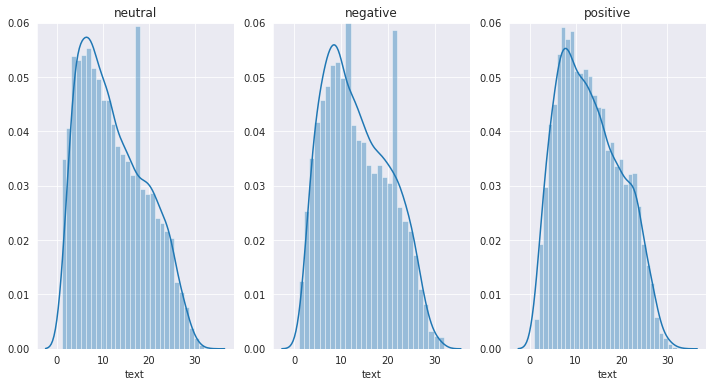

In [76]:
fig,ax = plt.subplots(1,3,figsize=(12,6))
for i, sentiment in enumerate(sentiments):
    sns.distplot(groups.get_group(sentiment).str.split().str.len(), ax=ax[i], hist=True, kde=True)
    ax[i].set_ylim(0, 0.06)
    ax[i].set_title(sentiment)

Как видим, пока что не было замечено никаких аномалий в данных.

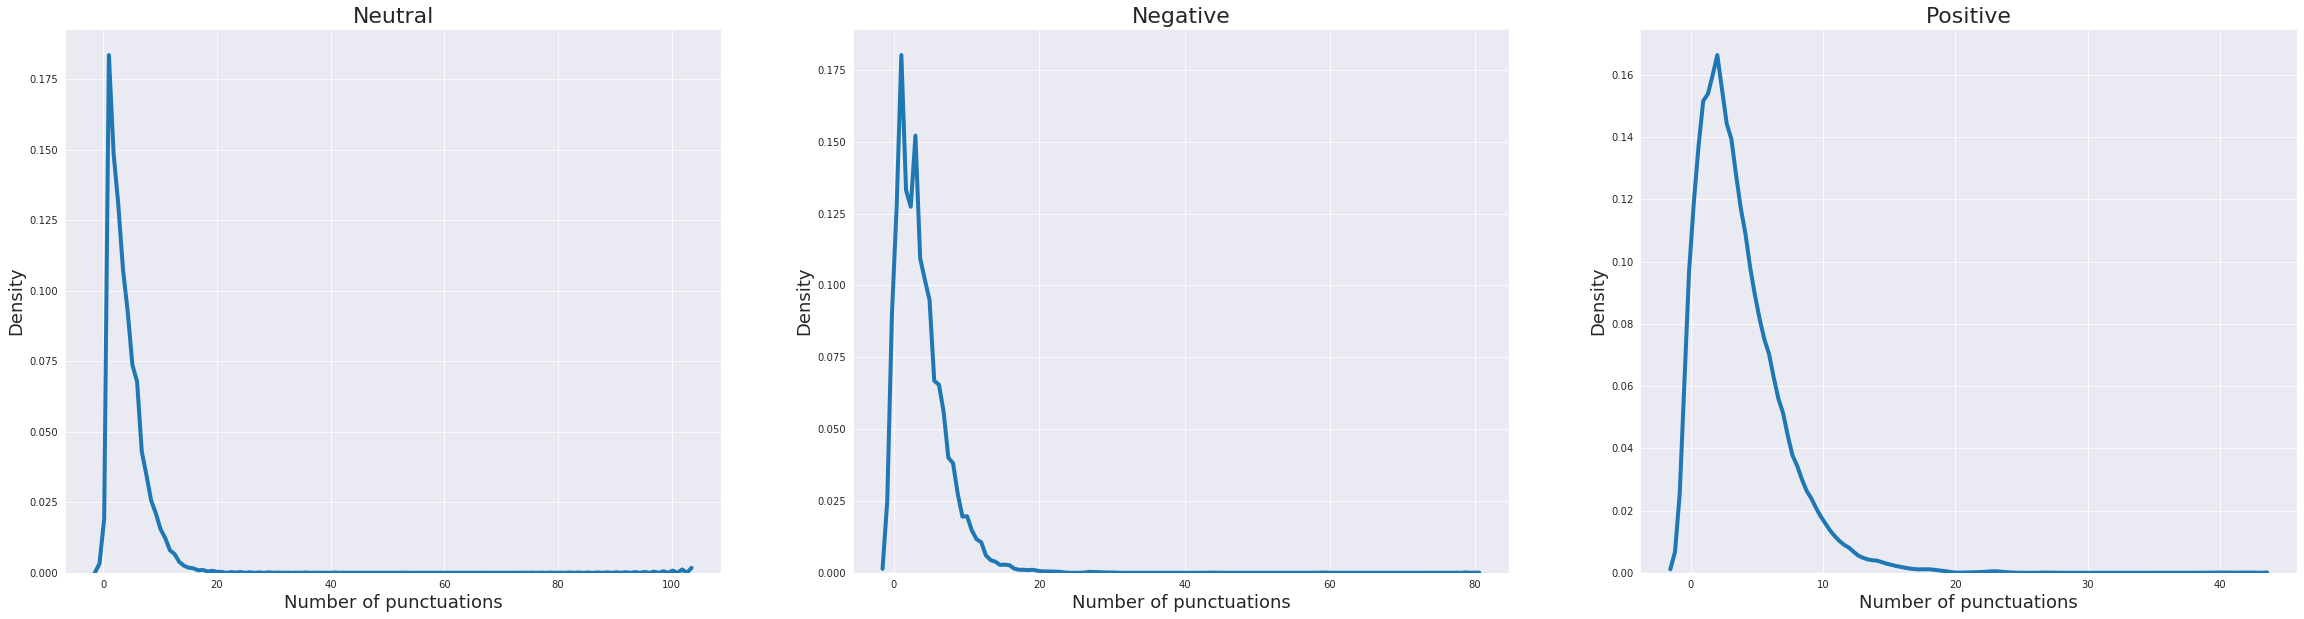

In [77]:
puncts = set(string.punctuation)

df['punct'] = df['text'].apply(lambda row: list(filter(lambda x: x in puncts, str(row))))
groups_1 = df.groupby('sentiment')['punct']
fig,ax = plt.subplots(1, 3,figsize=(40,10))
for axis, sentiment in zip(ax, df['sentiment'].unique()):
    sns.distplot(groups_1.get_group(sentiment).apply(len),
                hist=False,
                 kde=True,
                 bins=20,
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4},
                ax=axis)
    axis.set_xlabel("Number of punctuations", fontsize=18)
    axis.set_ylabel("Density", fontsize=18)
    axis.set_title(sentiment.capitalize(), fontsize=22)

Легко заметить, что в текстах с позитивным сантиментом встречается больше знаков пунктуации.

# **Попробуем найти закономерности в том, какие элементы чаще всего встречаются в твитах: проведем частотный анализ по знакам пунктуации и токенам.**

In [78]:
from allennlp.data.tokenizers.word_splitter import SpacyWordSplitter
from allennlp.data.token_indexers import SingleIdTokenIndexer

# the token indexer is responsible for mapping tokens to integers
token_indexer = SingleIdTokenIndexer()

def tokenizer(x: str):
    return [w.text for w in
            SpacyWordSplitter(language='en_core_web_sm', 
                              pos_tags=False).split_words(x)]

In [79]:
df['tokens'] = df['text'].apply(lambda row:tokenizer(str(row)))

In [80]:
groups2 = df.groupby("sentiment")

## Распределение знаков пунктуации:

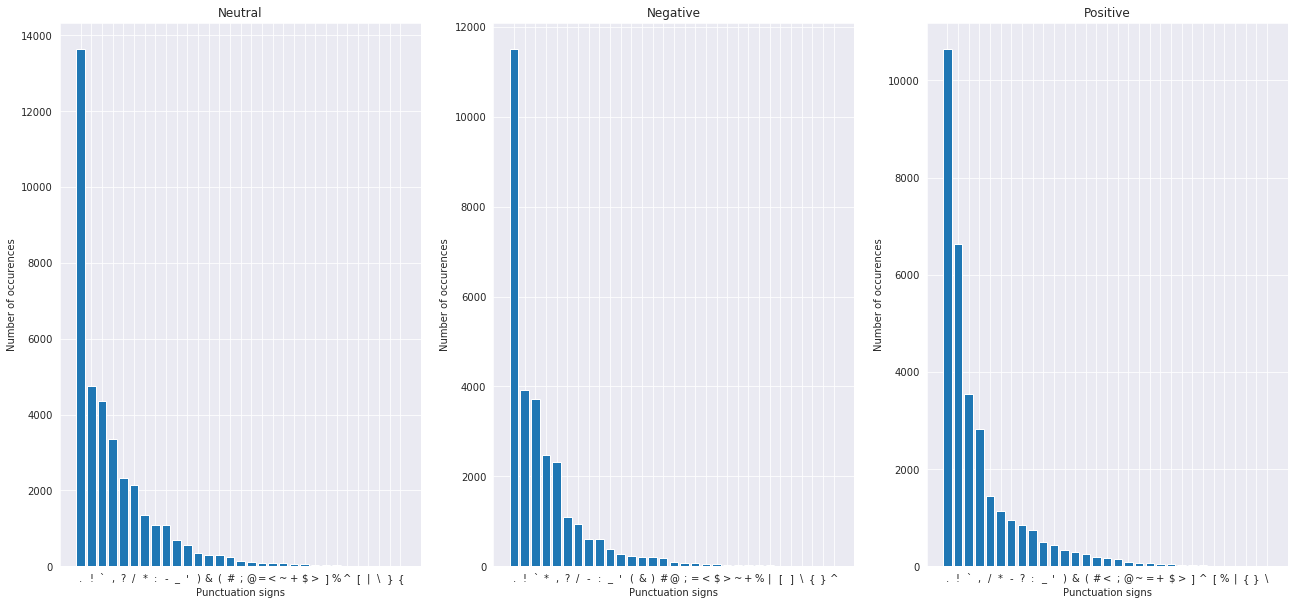

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(22, 10))
for axis, sentiment in zip(ax, sentiments):
    x, y = zip(*collections.Counter(list(itertools.chain.from_iterable(groups2.get_group(sentiment)['punct'].tolist()))).most_common())
    axis.bar(x, y)
    axis.set_xlabel("Punctuation signs")
    axis.set_ylabel("Number of occurences")
    axis.set_title(sentiment.capitalize())

## Распределение всех символов:

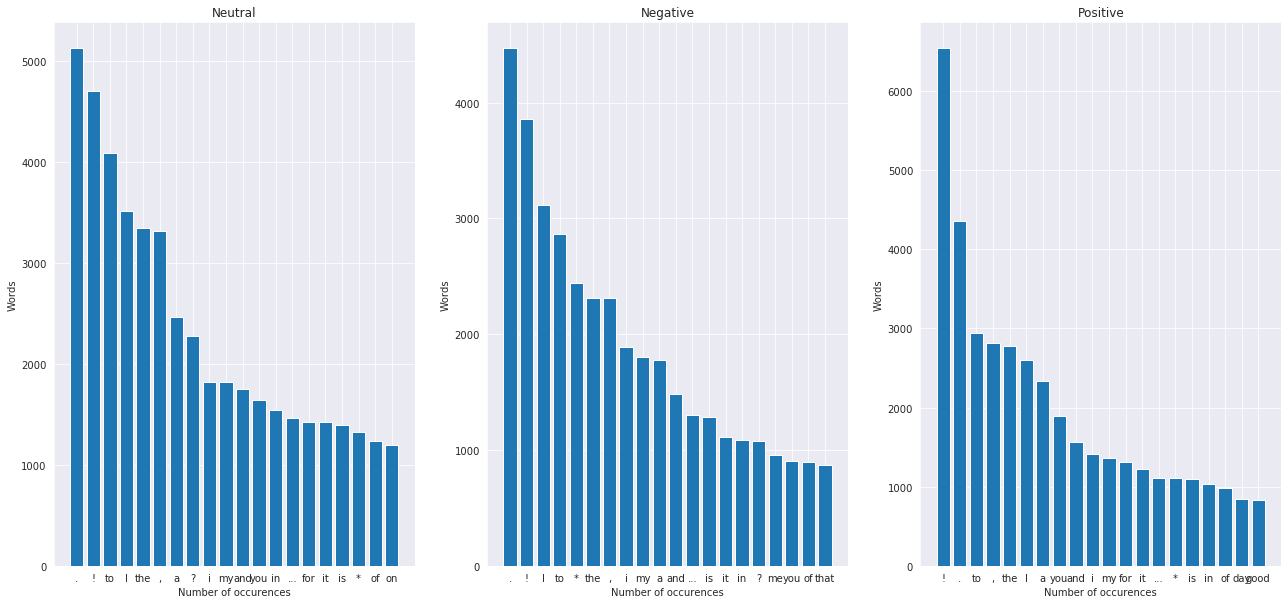

In [82]:
fig, ax = plt.subplots(1, 3, figsize=(22, 10))
for axis, sentiment in zip(ax, sentiments):
    x, y = zip(*collections.Counter(list(itertools.chain.from_iterable(groups2.get_group(sentiment)['tokens'].tolist()))).most_common()[:20])
    axis.bar(x, y)
    axis.set_xlabel("Number of occurences")
    axis.set_ylabel("Words")
    axis.set_title(sentiment.capitalize())

## Облака наиболее часто встречабщихся слов по эмоциональной окраске

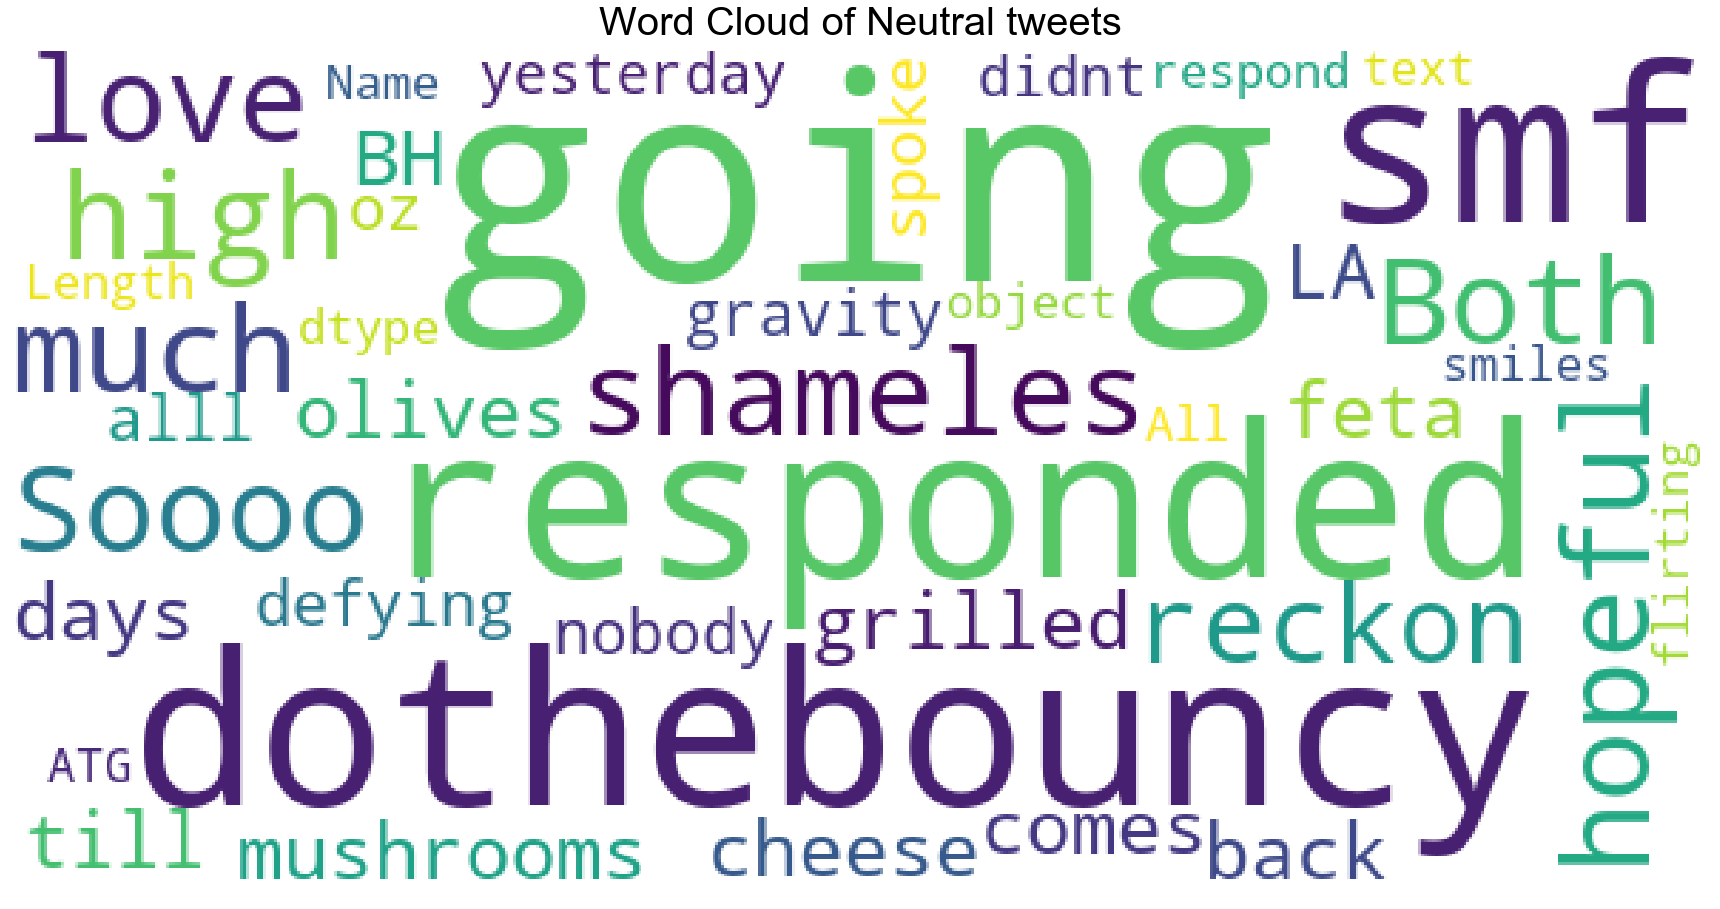

In [116]:
plot_wordcloud(df.loc[df['sentiment'] == 'neutral', 'text'], title="Word Cloud of Neutral tweets",color = 'white')

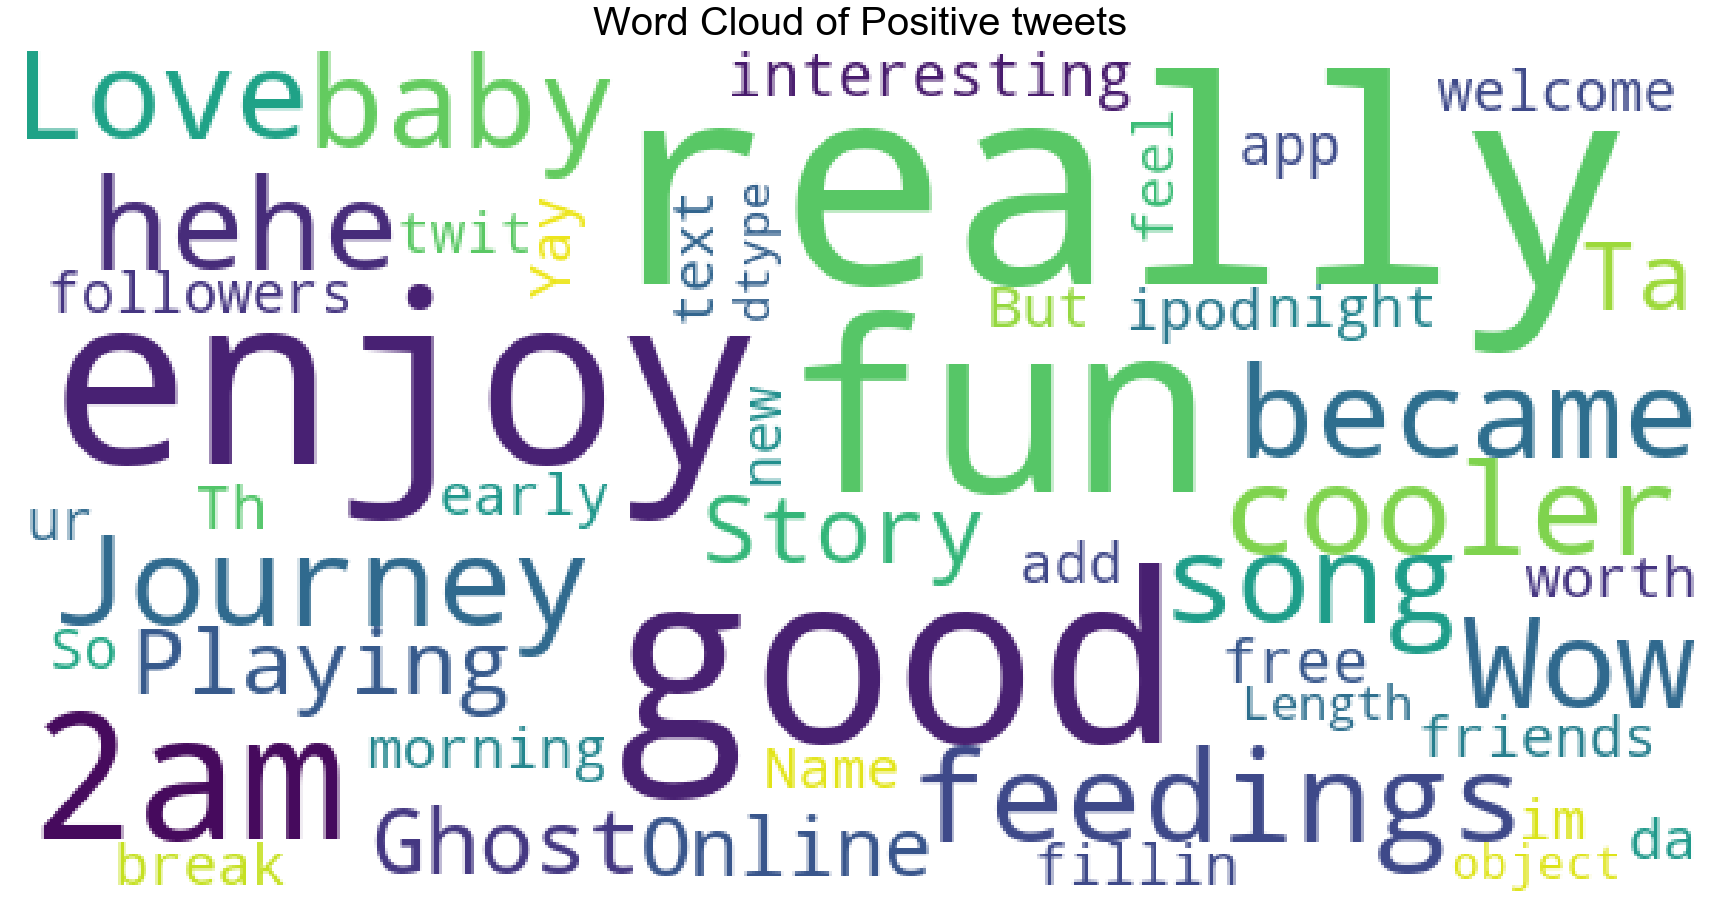

In [118]:
plot_wordcloud(df.loc[df['sentiment'] == 'positive', 'text'], title="Word Cloud of Positive tweets",color = 'white')

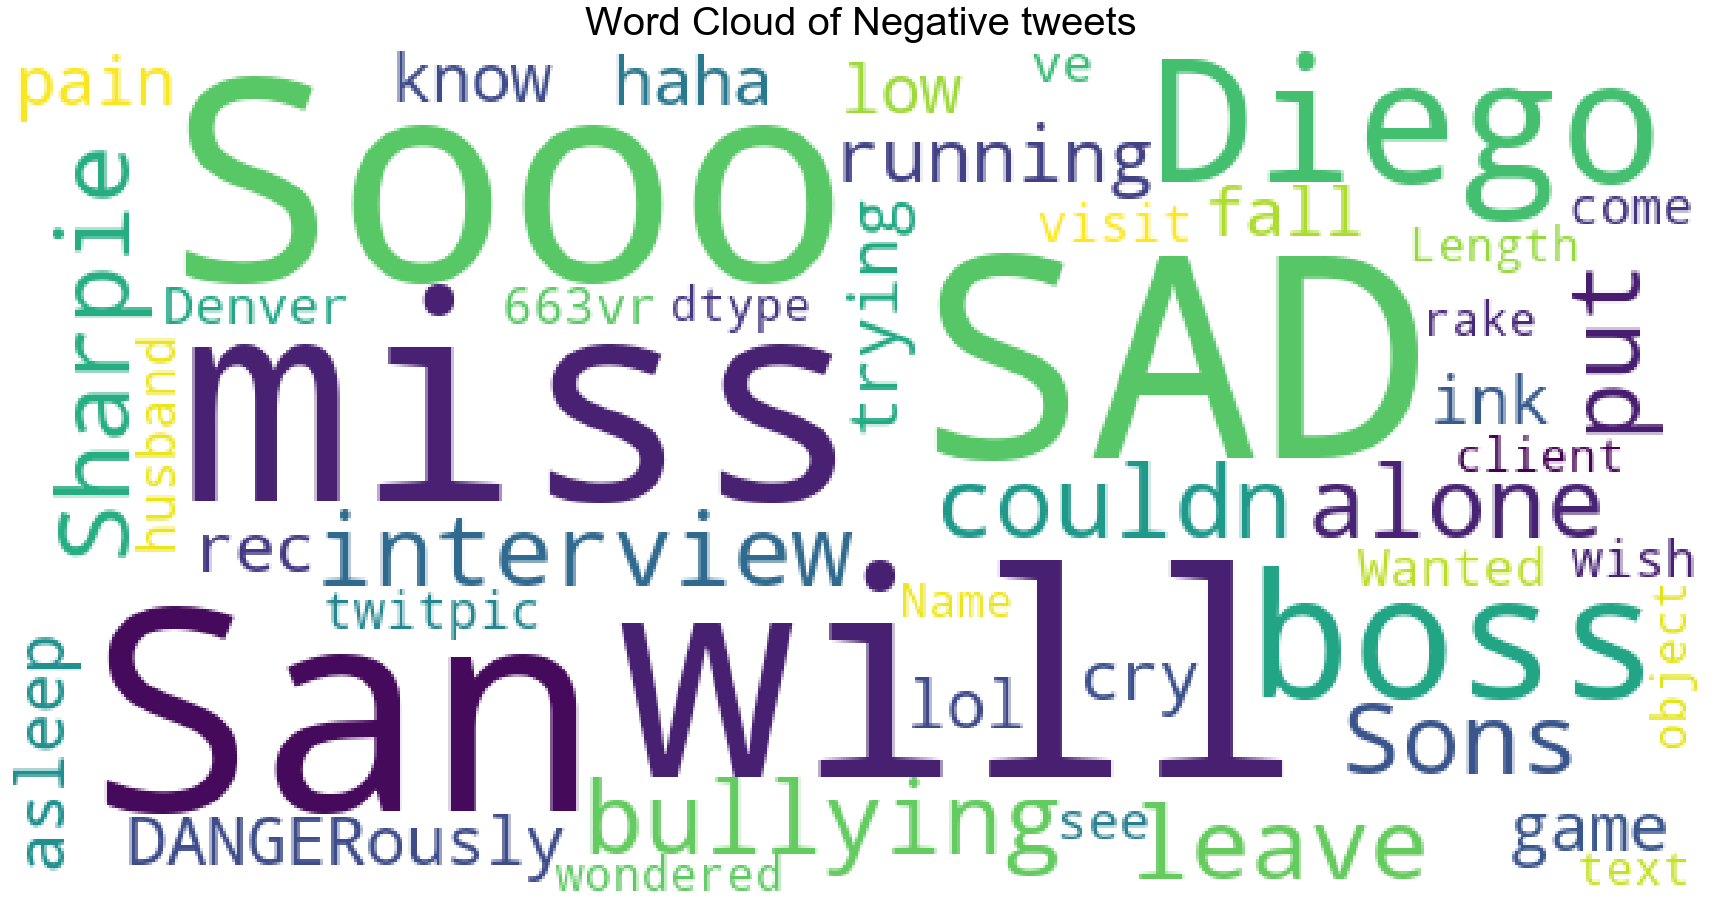

In [119]:
plot_wordcloud(df.loc[df['sentiment'] == 'negative', 'text'], title="Word Cloud of Negative tweets",color = 'white')

In [145]:
?clean

In [151]:
train_df = copy.deepcopy(df)
train_df = clean_df(train_df)

# Распределение слов:

 ##  Распределение три-грамм слов:

/Users/alex/.env/lib/python3.7/site-packages/ipykernel_launcher.py:162: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


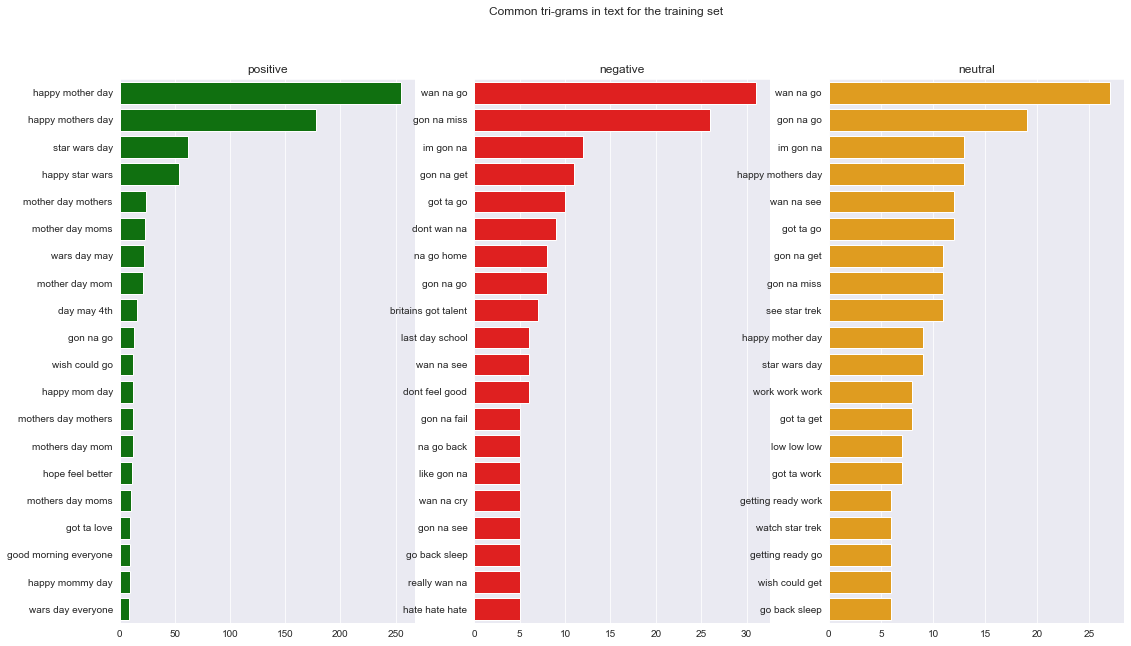

In [152]:
plot_n_grams(train_df.dropna(), size=3, 
                 title="Common tri-grams in text for the training set",
                 column="text")


In [83]:
df['tokens_no_punct'] = df['text'].apply(lambda row: tokenizer(basic_cleaning(str(row))))

In [84]:
groups3 = df.groupby("sentiment")

In [85]:
def preprocess_tweets(dataframe: pd.core.frame.DataFrame, n:int = 3, column: str = 'text') -> list:
    return dataframe[column].apply(lambda row: (lambda arr: list(filter(lambda x: len(x) >= n and len(puncts.intersection(x)) == 0, arr)))(tokenizer(str(row)))).tolist()

## Распределение биграмм слов:

/Users/alex/.env/lib/python3.7/site-packages/ipykernel_launcher.py:162: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


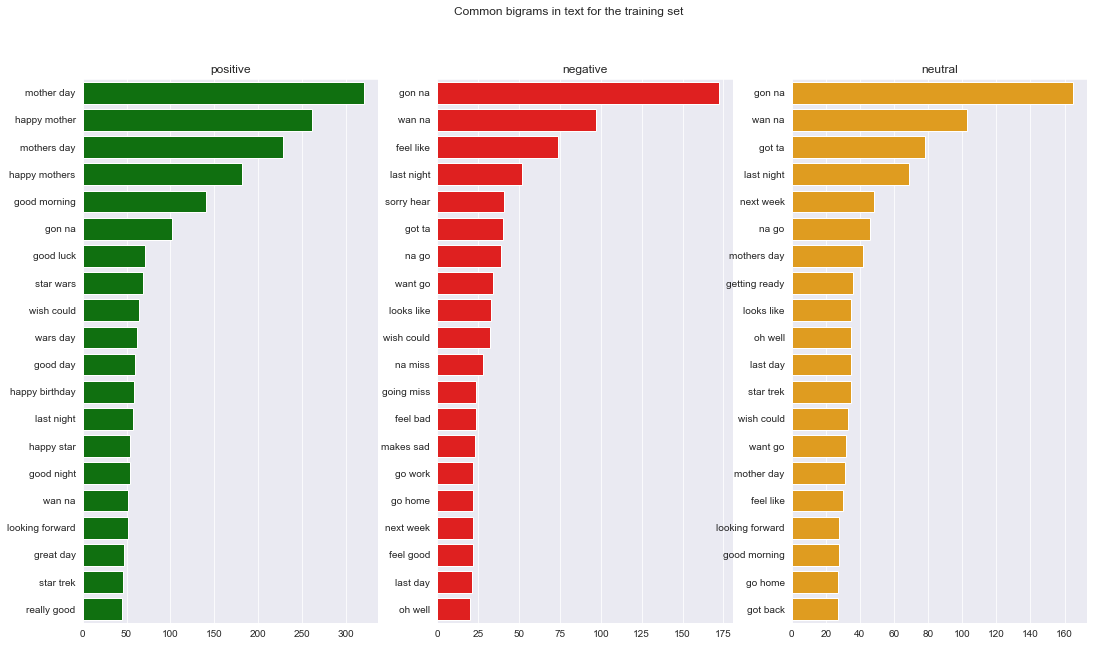

In [154]:
plot_n_grams(train_df.dropna(), size=2, 
                 title="Common bigrams in text for the training set",
                 column="text")

## Распределение монограмм слов:

## 1. При наименьшей длинне слова, равной 3м символам:

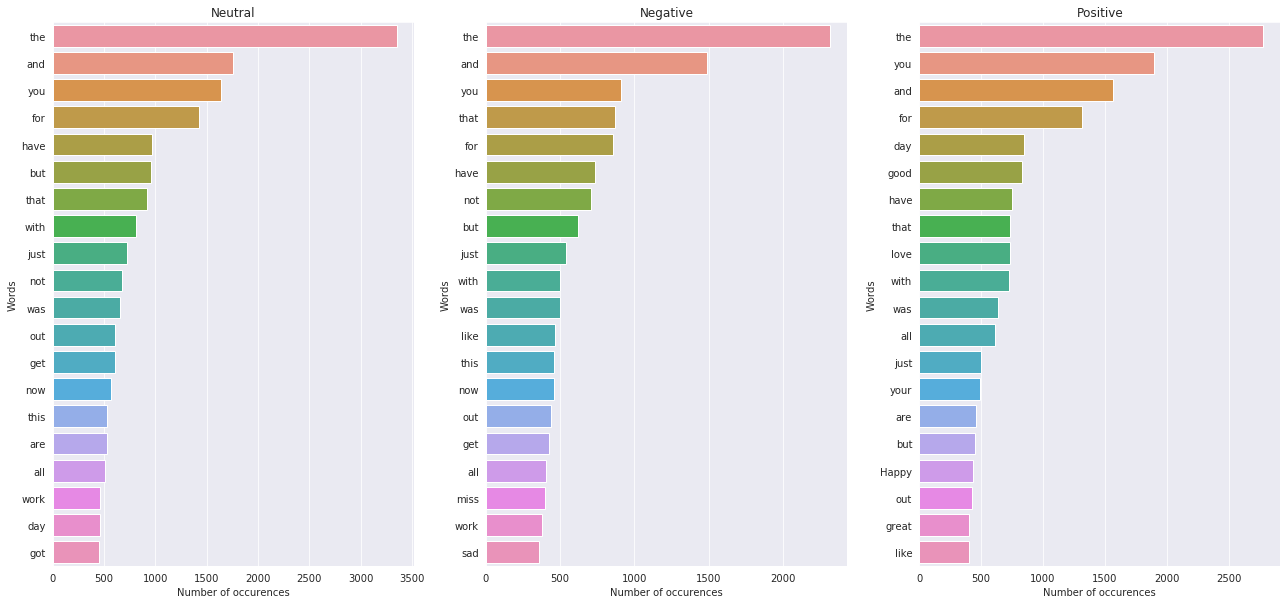

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(22, 10))
for axis, sentiment in zip(ax, sentiments):
    #x, y = zip(*collections.Counter(list(itertools.chain.from_iterable(groups3.get_group(sentiment)['tokens_no_punct'].tolist()))).most_common()[:20])
    x, y = zip(*collections.Counter(itertools.chain.from_iterable(preprocess_tweets(groups3.get_group(sentiment), n=3))).most_common()[:20])
    sns.barplot( x = y, y = list(x), ax=axis)
    axis.set_xlabel("Number of occurences")
    axis.set_ylabel("Words")
    axis.set_title(sentiment.capitalize())

## 2. При наименьшей длинне слова, равной 4м символам:

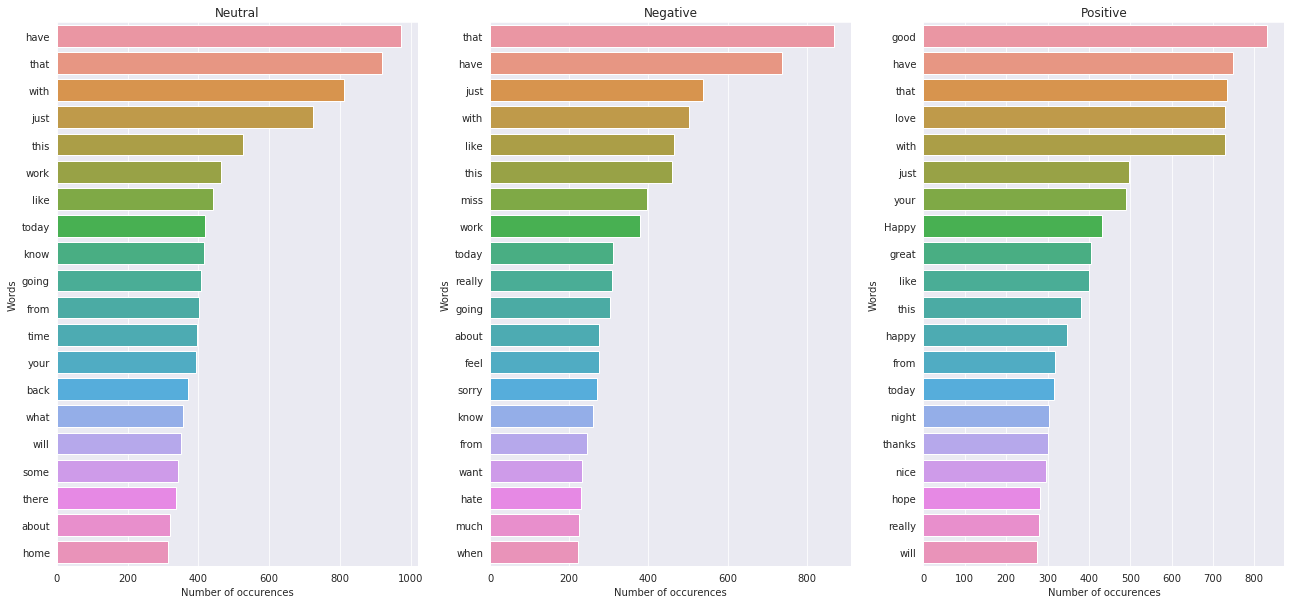

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(22, 10))
for axis, sentiment in zip(ax, sentiments):
    #x, y = zip(*collections.Counter(list(itertools.chain.from_iterable(groups3.get_group(sentiment)['tokens_no_punct'].tolist()))).most_common()[:20])
    x, y = zip(*collections.Counter(itertools.chain.from_iterable(preprocess_tweets(groups3.get_group(sentiment), n=4))).most_common()[:20])
    sns.barplot( x = y, y = list(x), ax=axis)
    axis.set_xlabel("Number of occurences")
    axis.set_ylabel("Words")
    axis.set_title(sentiment.capitalize())

## 3. При наименьшей длинне слова, равной 5ти символам:

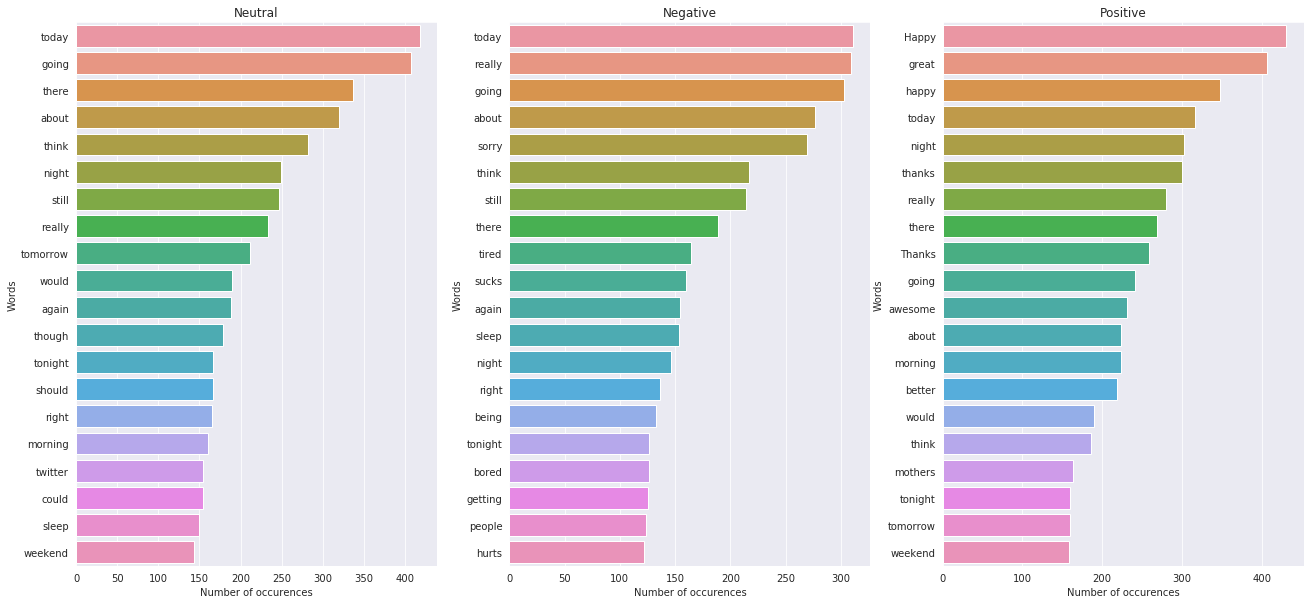

In [88]:
fig, ax = plt.subplots(1, 3, figsize=(22, 10))
for axis, sentiment in zip(ax, sentiments):
    #x, y = zip(*collections.Counter(list(itertools.chain.from_iterable(groups3.get_group(sentiment)['tokens_no_punct'].tolist()))).most_common()[:20])
    x, y = zip(*collections.Counter(itertools.chain.from_iterable(preprocess_tweets(groups3.get_group(sentiment), n=5))).most_common()[:20])
    sns.barplot( x = y, y = list(x), ax=axis)
    axis.set_xlabel("Number of occurences")
    axis.set_ylabel("Words")
    axis.set_title(sentiment.capitalize())